In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime

### Немного переделал под Python 3

Вводные

Водитель может находиться в 4 возможных статусах:
    * free -- доступен для нового заказа
    * enroute -- едет на заказ
    * ontrip -- выполняет заказ
    * busy -- недоступен для нового заказа

Возможные переходы из одного состояние в другое определены как:
    * free -> [free, enroute, busy]
    * enroute -> [free, ontrip]
    * ontrip -> [free]
    * busy -> [free]

Почему переходы определяются таким образом:
1. Из состояния free можно перейти в
    * free -- если водитель ушел в офлайн и заново вышел на линию, тогда подряд будет две записи со статусом free
    * enroute -- если водитель принял заказ, то переходит в статус enroute и едет к клиенту
    * busy -- если водитель нажал кнопку "Занят" в таксометре (пошел на обед и т.д.)
2. Из состояния enroute можно перейти в 
    * free -- если клиент или водитель отменил заказ
    * ontrip -- если водитель приехал к клиенту и начал выполнять заказ
3. Из состояния ontrip можно перейти только в free (после выполнения заказа)
4. Из состояния busy можно перейти только в free

Эффективность на поездке -- это время с клиентом в машине (ontrip), деленное на сумму длительностей всех статусов, связанных с поездкой (sum(free) + enroute + ontrip), где sum(free) -- время простоя.

Время простоя -- это сумма всех статусов free, предшествующих поездке. Суммируются все статусы free, идущие подряд, а также те, которые были прерваны короткими статусами busy или enroute (короткий статус == меньше какого-то TIMEOUT'а).

Имеется набор данных со статусами водителей, по которому необходимо построить зависимость длительности поездки от эффективности.
    * driver_id -- id водителя
    * status -- один из статусов
    * dttm -- время начала статуса

Примечания:
    * Поездка считается только при наличии статуса ontrip
    * Тесты написаны для python 2

    1. Написать функцию-генератор, которая будет отдавать соседние элементы в цикле. Функция понадобится для итерирования по записям водителя и проверки соседних статусов по условиям. Не забудьте проверить, что тесты проходят без ошибок (см. test_neighbors).

In [17]:
def neighbors(iterable):
    # Write generator function which yields 
    # previous, current and next values in iterable list.
    # ... type your code here ...
    list_iterable = [None] + list(iterable) + [None]
    pointer = 1
    
    for item in iterable:
        #print(list_iterable, pointer)
        yield (list_iterable[pointer - 1], list_iterable[pointer], list_iterable[pointer + 1])
        pointer += 1

In [18]:
# Check if test passes
def test_neighbors():
    test_neighbors = neighbors( range(2) )
    #assert test_neighbors.next() == (None, 0, 1)
    assert next(test_neighbors) == (None, 0, 1)

print(test_neighbors())

None


    2. Сгруппировать данные на уровне водителя таким образом, чтобы в одной строке находились все его записи со статусами и началом статуса списком:

Формат исходной таблицы:
<table>
<tr><td>driver_id</td><td>status</td><td>dttm</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>free</td><td>2018-02-04 00:19</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>busy</td><td>2018-02-04 01:03</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>free</td><td>2018-02-03 15:43</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>enroute</td><td>2018-02-03 17:02</td></tr>
<tr><td>...</td><td>...</td><td>...</td></tr>
</table>

Формат сгруппированной таблицы:
<table>
<tr><td>driver_id</td><td>driver_info</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>[("free", 2018-02-04 00:19), ("busy", 2018-02-04 01:03)]</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>[("free", 2018-02-03 15:43), ("enroute", 2018-02-03 17:02) ...]</td></tr>
</table>

In [33]:
#df = pd.read_csv(".../dataset.csv", parse_dates=["dttm"])
df = pd.read_csv("dataset.csv", parse_dates=["dttm"])
# ... type your code here ...
groupped_dict = {}
for driver_id, tmp_df in df.groupby('driver_id'):
    tmp_df = tmp_df.sort_values('dttm')
    groupped_dict[driver_id] = list(zip(tmp_df.status, tmp_df.dttm))
groupped_df = pd.Series(groupped_dict).reset_index()
groupped_df.columns = ['driver_id', 'driver_info']
groupped_df.head()

,driver_id,driver_info
0,029e9b80b45c483fbb00c4695c2d9c09,"[(free, 2018-02-18 20:01:18.620339), (enroute,..."
1,041ddc65a16649129eb6dbee9b54d6e8,"[(free, 2018-02-18 19:56:21.620339), (busy, 20..."
2,048459e02e63450d9429ceb34601929d,"[(free, 2018-02-18 19:49:55.620339), (enroute,..."
3,0f8eccff510f4bdabbff9f40b2262517,"[(free, 2018-02-18 21:02:40.620339), (busy, 20..."
4,14637bc848b24ac49fbadc43d207e375,"[(free, 2018-02-18 20:36:13.620339), (enroute,..."


    3. Используя функцию neighbors, написать функцию, которая для каждой записи в списке driver_info посчитает ее длительность.

In [56]:
def calc_status_duration(driver_info):
    driver_info_updated = []
    for i, j, k in neighbors(driver_info):
        # ... type your code here ...
        if k != None:
            driver_info_updated.append(j + ((k[1] - j[1]).total_seconds(),))
        else:
            driver_info_updated.append(j + (None,))
    return driver_info_updated

In [58]:
# Check if test passes
def test_calc_status_duration():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19)), 
                          ("busy", datetime(2018, 4, 2, 1, 3)),]
    sample_driver_info_updated = [('free', datetime(2018, 4, 2, 0, 19), 2640.0),
                                  ('busy', datetime(2018, 4, 2, 1, 3), None),]
    assert calc_status_duration(sample_driver_info) == sample_driver_info_updated

test_calc_status_duration()

In [60]:
df = groupped_df.copy()
df["driver_info"] = df.driver_info.apply(calc_status_duration)

    4. Используя функцию neighbors, написать функцию, которая сформирует из списка driver_info список поездок с информацией о длительности поездки и эффективности (duration_ontrip, efficiency).

In [61]:
df.head()

,driver_id,driver_info
0,029e9b80b45c483fbb00c4695c2d9c09,"[(free, 2018-02-18 20:01:18.620339, 2499.0), (..."
1,041ddc65a16649129eb6dbee9b54d6e8,"[(free, 2018-02-18 19:56:21.620339, 2862.0), (..."
2,048459e02e63450d9429ceb34601929d,"[(free, 2018-02-18 19:49:55.620339, 1233.0), (..."
3,0f8eccff510f4bdabbff9f40b2262517,"[(free, 2018-02-18 21:02:40.620339, 1574.0), (..."
4,14637bc848b24ac49fbadc43d207e375,"[(free, 2018-02-18 20:36:13.620339, 1271.0), (..."


In [93]:
TIMEOUT = 1600

def collapse_statuses(driver_info):
    # Here define conditions under which the "free" state 
    # should be attributed to the trip.
    # ... type your code here ...
    time = 0
    trips = []
    for i, j, k in neighbors(driver_info):
        if k == None:
            break
        if (j[0] in ['enroute', 'busy']) and (k[0] == 'free') and (j[2] >= TIMEOUT):
            time = 0
        elif (j[0] == 'enroute') and (k[0] == 'free'):
            pass
        elif (j[0] == 'ontrip') and (k[0] == 'free'):
            time += j[2]
            trips.append((j[2], j[2] / time))
            time = 0
        elif (j[2] != None):
            time += j[2]
    return trips

In [88]:
# Check if test passes
def test_collapse_statuses():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19), 2640.0), 
                          ("busy", datetime(2018, 4, 2, 1, 3), 1660.0),
                          ("free", datetime(2018, 4, 2, 1, 30, 40), 2050.0),
                          ("enroute", datetime(2018, 4, 2, 2, 4, 50), 70.0),
                          ("free", datetime(2018, 4, 2, 2, 6), 500.0),
                          ("enroute", datetime(2018, 4, 2, 2, 14, 20), 520.0),
                          ("ontrip", datetime(2018, 4, 2, 2, 23), 3060.0),
                          ("free", datetime(2018, 4, 2, 3, 14), None)
                         ]
    sample_driver_info_updated = [(3060.0, 3060.0 / (3060.0 + 520.0 + 500.0 + 2050.0))]
    assert collapse_statuses(sample_driver_info) == sample_driver_info_updated

test_collapse_statuses()

In [95]:
df["driver_info"] = df.driver_info.apply(collapse_statuses)

In [96]:
df.head()

,driver_id,driver_info
0,029e9b80b45c483fbb00c4695c2d9c09,"[(4561.0, 0.4108268780399928), (3622.0, 0.3631..."
1,041ddc65a16649129eb6dbee9b54d6e8,"[(2985.0, 0.41724909141738886), (5845.0, 0.558..."
2,048459e02e63450d9429ceb34601929d,"[(1116.0, 0.2014076881429345), (5261.0, 0.2796..."
3,0f8eccff510f4bdabbff9f40b2262517,"[(2780.0, 0.2212847249860702), (3580.0, 0.2961..."
4,14637bc848b24ac49fbadc43d207e375,"[(4526.0, 0.4395028160807924), (149.0, 0.01055..."


    5. Нарисовать и проинтерпретировать зависимость между длительностью поездки и эффективностью.
    Подсказка: требуется сделать обратное преобразование из таблицы со строками на уровне водителя в таблицу со строками на уровне поездки.

In [104]:
res_df = pd.DataFrame(df.driver_info.sum(), columns=['ontrip', 'efficiency'])
res_df.head()

,ontrip,efficiency
0,4561.0,0.410827
1,3622.0,0.363144
2,2985.0,0.417249
3,5845.0,0.558049
4,1074.0,0.124840


In [124]:
import statsmodels.api as sm

sm_results = sm.OLS(res_df.efficiency, sm.add_constant(res_df.ontrip)).fit()

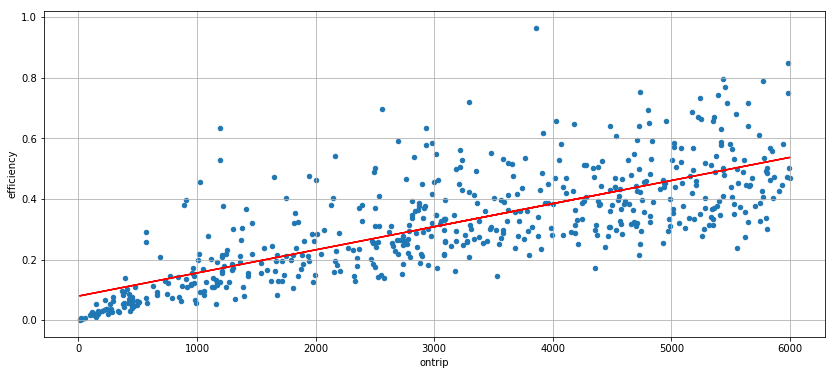

In [125]:
import matplotlib.pyplot as plt

lin_y = res_df.ontrip.map(lambda x: x*sm_results.params.ontrip + sm_results.params.const)
res_df.plot.scatter(x = 'ontrip', y = 'efficiency', figsize=(14,6), grid=True)
plt.plot(res_df.ontrip, lin_y, color = 'r')

На уровне зависимости видим выраженный положительный тренд. Взаимосвязь ожидаема: с ростом времени поездки в формуле efficiency наибольший рост характерен для параметра ontrip. Время простоя и enroute растут с существенно меньшей скоростью либо остаются константны (с некоторым шумом) - как минимум, между временем простоя + enroute и временем поездки нет линейной взаимосвязи.

Взаимосвязь более точно аппроксимируется гиперболой - видимо, поездки с наибольшей длительностью требуют большего времени enroute (аэропорт, подмосковье, т.п.). Большая часть поездок (визуально) имеет небольшую продолжительность и, соответственно, эффективность - вероятно, они приходятся на город с высоким временем простоя и использованием такси в тех случаях, когда маршрут через метро неоптимален.